In [259]:
import pandas as pd
import matplotlib.pyplot as plt 
#plt.rcParams["figure.figsize"] = (9,6) 
#plt.rcParams["font.family"] = "sans-serif"

plt.rcParams.update(plt.rcParamsDefault)


plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

from matplotlib.pyplot import figure
import matplotlib.cm as cm

plt.style.use('ggplot')
cmap = cm.get_cmap('Blues')

import numpy as np

#### Load Data

In [260]:
# single gpu

# stopping
gpu1_1e14_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e14_stopping_training_data.csv')
gpu1_1e15_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e15_stopping_training_data.csv')
gpu1_1e16_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e16_stopping_training_data.csv')

# no stopping
gpu1_1e14 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e14_training_data.csv')
gpu1_1e15 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e15_training_data.csv')
gpu1_1e16 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e16_training_data.csv')

# four gpu

# stopping
gpu4_1e14_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e14_stopping_training_data.csv')
gpu4_1e15_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e15_stopping_training_data.csv')
gpu4_1e16_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e16_stopping_training_data.csv')

# no stopping
gpu4_1e14 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e14_training_data.csv')
gpu4_1e15 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e15_training_data.csv')
gpu4_1e16 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e16_training_data.csv')


## Epoch Savings

For epoch savings, the number of GPUs should be (?) irrelevant, so we just use the different GPUs as repeated tests. It doesn't seem to be irrelevant, though. We should look into that. Is it just random? Should do more tests to find out.

In [261]:
import math
num_epochs_without_stopping = len(gpu1_1e14.index)

num_epochs_with_stopping_1e14 = [len(gpu1_1e14_stopping.index), len(gpu4_1e14_stopping.index)]
num_epochs_with_stopping_1e15 = [len(gpu1_1e15_stopping.index), len(gpu4_1e15_stopping.index)]
num_epochs_with_stopping_1e16 = [len(gpu1_1e16_stopping.index), len(gpu4_1e16_stopping.index)]

avg_epochs_completed_1e14 = sum(num_epochs_with_stopping_1e14)/len(num_epochs_with_stopping_1e14)
avg_epochs_completed_1e15 = sum(num_epochs_with_stopping_1e15)/len(num_epochs_with_stopping_1e15)
avg_epochs_completed_1e16 = sum(num_epochs_with_stopping_1e16)/len(num_epochs_with_stopping_1e16)

print("Avg. epochs completed for 1e14:", avg_epochs_completed_1e14)
print("Avg. epochs completed for 1e15:", avg_epochs_completed_1e15)
print("Avg. epochs completed for 1e16:", avg_epochs_completed_1e16)

percent_epochs_saved_1e14 = 1-(avg_epochs_completed_1e14/num_epochs_without_stopping)
percent_epochs_saved_1e15 = 1-(avg_epochs_completed_1e15/num_epochs_without_stopping)
percent_epochs_saved_1e16 = 1-(avg_epochs_completed_1e16/num_epochs_without_stopping)

print("Avg. percent epochs saved for 1e14:", percent_epochs_saved_1e14*100)
print("Avg. percent epochs saved for 1e15:", percent_epochs_saved_1e15*100)
print("Avg. percent epochs saved for 1e16:", percent_epochs_saved_1e16*100)



Avg. epochs completed for 1e14: 2134.0
Avg. epochs completed for 1e15: 1573.0
Avg. epochs completed for 1e16: 1688.0
Avg. percent epochs saved for 1e14: 14.639999999999997
Avg. percent epochs saved for 1e15: 37.08
Avg. percent epochs saved for 1e16: 32.48


[[0.57960784 0.77019608 0.87372549 1.        ]
 [0.23192618 0.54565167 0.76261438 1.        ]
 [0.03137255 0.28973472 0.57031911 1.        ]]
Baseline (2500, 2500, 2500)
1GPU with PENGUIN (2167, 1647, 1737)
4GPU with PENGUIN (2101, 1499, 1639)


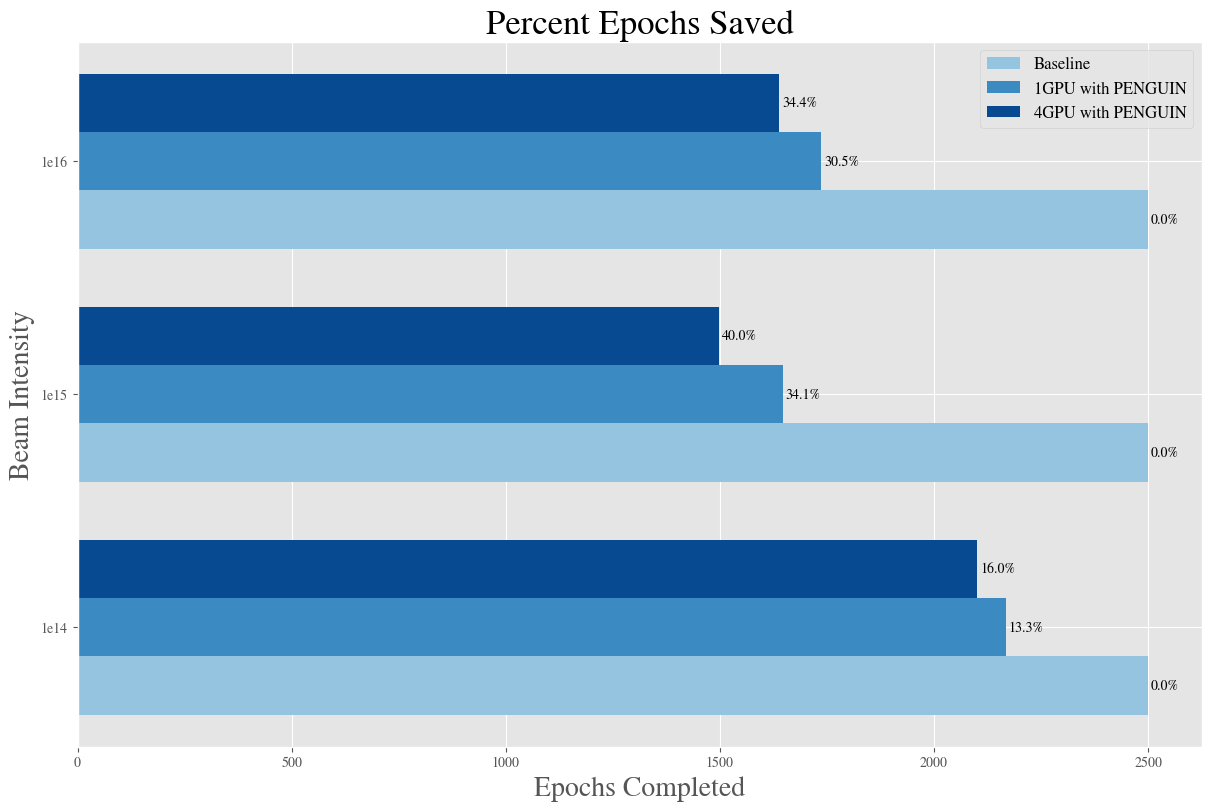

In [271]:



width = 0.2
multiplier = 0

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

beam_intensity = ("1e14", "1e15", "1e16")
epochs_run = {
    'Baseline': (num_epochs_without_stopping, num_epochs_without_stopping, num_epochs_without_stopping),
    '1GPU with PENGUIN': (len(gpu1_1e14_stopping.index), len(gpu1_1e15_stopping.index), len(gpu1_1e16_stopping.index)),
    '4GPU with PENGUIN': (len(gpu4_1e14_stopping.index), len(gpu4_1e15_stopping.index), len(gpu4_1e16_stopping.index)),
}

x = np.arange(len(beam_intensity))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))
colors = cmap(np.linspace(0.4, 0.9, 3))
print(colors)

for index, (label, num_epochs) in enumerate(epochs_run.items()):
    print(label, num_epochs)
    offset = width * multiplier
    rects = ax.barh(x + offset, num_epochs, width, label=label, color=colors[index]) #, color= cmap(np.linspace(0, 1, 3))
    labels = [str(round((1-(num_epochs[i]/num_epochs_without_stopping))*100, 1))+'%' for i in range(len(num_epochs))]
    ax.bar_label(rects, labels=labels ,padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Epochs Completed', fontsize=20)
ax.set_ylabel('Beam Intensity', fontsize=20)

ax.set_title('Percent Epochs Saved', fontsize=25)
ax.set_yticks(x + width, beam_intensity)
ax.legend(loc='upper right',fontsize=12)
# ax.set_ylim(0, 2500)

plt.savefig('figures/epochs_saved.png')

plt.show()


## Time Savings

Below is making and saving the time file (by hand, unfortuantely). This will be made automatic in subsequent runs.

In [263]:
from datetime import datetime, timedelta

def get_run_time(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time

def get_run_seconds(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time.total_seconds()

gpu=[1,1,1,1,1,1,4,4,4,4,4,4]
stopping=[False, False, False, True, True, True, False, False, False, True, True, True]
dataset=['14','15','16','14','15','16','14','15','16','14','15','16']
time=['2-02_01_42','2-03_52_23','2-00_38_20','1-22_33_04','1-12_05_38','1-08_18_16','0-14_32_18','0-14_54_32','0-13_53_12','0-12_03_46','0-09_10_05','0-09_27_38']

time_df = pd.DataFrame()
time_df['gpu'] = gpu
time_df['dataset'] = dataset
time_df['stopping'] = stopping
time_df['time'] = time
time_df['total_time'] = time_df['time'].apply(get_run_time)
time_df['total_seconds'] = time_df['time'].apply(get_run_seconds)
time_df.to_csv('./icpp_training_results/time_to_run.csv', index=False)

### Now we look at time savings

Need to think about how to graph this, though

In [264]:
time_df = pd.read_csv('./icpp_training_results/time_to_run.csv')
time_df.head()

,gpu,dataset,stopping,time,total_time,total_seconds
0,1,14,False,2-02_01_42,2 days 02:01:42,180102.0
1,1,15,False,2-03_52_23,2 days 03:52:23,186743.0
2,1,16,False,2-00_38_20,2 days 00:38:20,175100.0
3,1,14,True,1-22_33_04,1 days 22:33:04,167584.0
4,1,15,True,1-12_05_38,1 days 12:05:38,129938.0


1GPU without PENGUIN (50.028333333333336, 51.87305555555555, 48.638888888888886)
1GPU with PENGUIN (46.55111111111111, 36.09388888888889, 32.30444444444444)
4GPU without PENGUIN (14.538333333333334, 14.908888888888889, 13.886666666666667)
4GPU with PENGUIN (12.062777777777777, 9.168055555555556, 9.460555555555555)


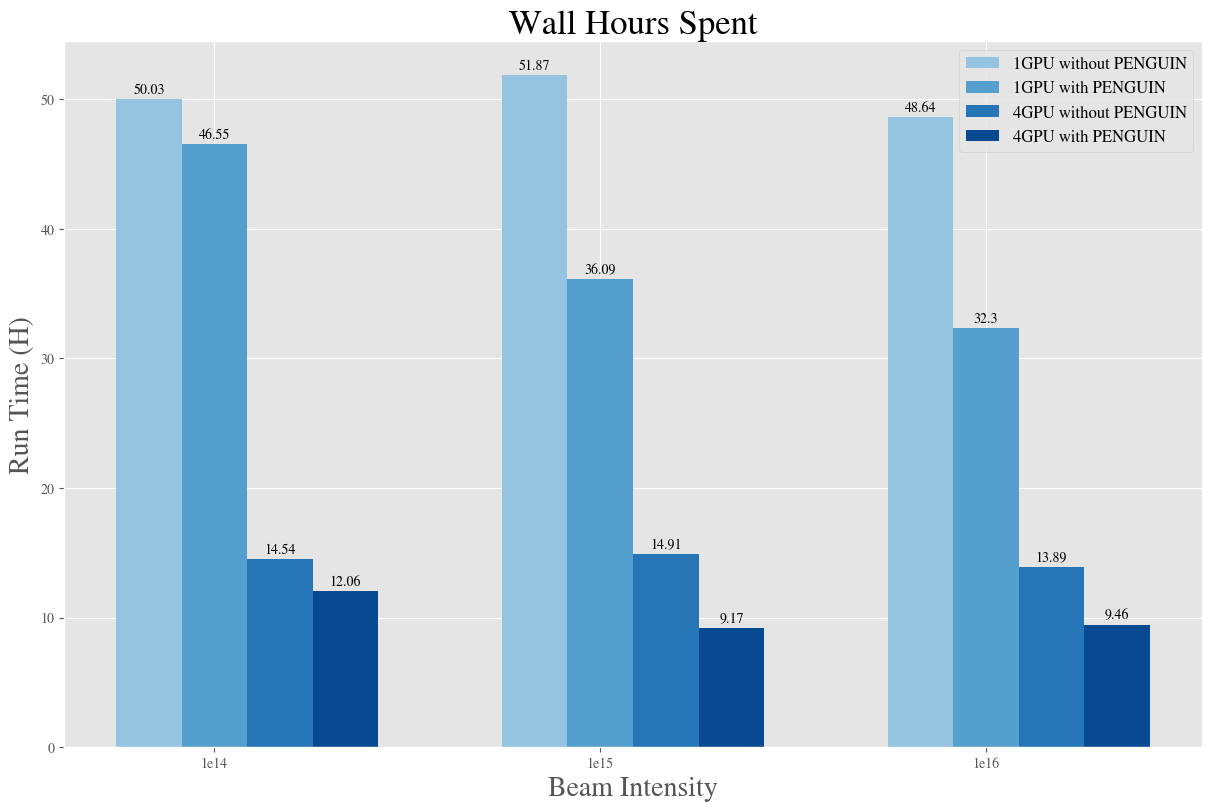

In [270]:

## prepping data
time_format='total_seconds'
e14_time = time_df[(time_df['dataset']==14)& (time_df['stopping']==False) & (time_df['gpu']==1)][time_format].item()/3600
e15_time = time_df[(time_df['dataset']==15)& (time_df['stopping']==False) & (time_df['gpu']==1)][time_format].item()/3600
e16_time = time_df[(time_df['dataset']==16)& (time_df['stopping']==False) & (time_df['gpu']==1)][time_format].item()/3600

e14_time_stopping = time_df[(time_df['dataset']==14)& (time_df['stopping']==True) & (time_df['gpu']==1)][time_format].item()/3600
e15_time_stopping = time_df[(time_df['dataset']==15)& (time_df['stopping']==True) & (time_df['gpu']==1)][time_format].item()/3600
e16_time_stopping = time_df[(time_df['dataset']==16)& (time_df['stopping']==True) & (time_df['gpu']==1)][time_format].item()/3600

gpu4_e14_time = time_df[(time_df['dataset']==14)& (time_df['stopping']==False) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e15_time = time_df[(time_df['dataset']==15)& (time_df['stopping']==False) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e16_time = time_df[(time_df['dataset']==16)& (time_df['stopping']==False) & (time_df['gpu']==4)][time_format].item()/3600

gpu4_e14_time_stopping = time_df[(time_df['dataset']==14)& (time_df['stopping']==True) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e15_time_stopping = time_df[(time_df['dataset']==15)& (time_df['stopping']==True) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e16_time_stopping = time_df[(time_df['dataset']==16)& (time_df['stopping']==True) & (time_df['gpu']==4)][time_format].item()/3600

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

beam_intensity = ("1e14", "1e15", "1e16")
epochs_run = {
    '1GPU without PENGUIN': (e14_time, e15_time, e16_time),
    '1GPU with PENGUIN': (e14_time_stopping, e15_time_stopping, e16_time_stopping),
    '4GPU without PENGUIN': (gpu4_e14_time, gpu4_e15_time, gpu4_e16_time),
    '4GPU with PENGUIN': (gpu4_e14_time_stopping, gpu4_e15_time_stopping, gpu4_e16_time_stopping),
}

x = np.arange(len(beam_intensity))  # the label locations
width = 0.17  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))
colors = cmap(np.linspace(0.4, 0.9, 4))

for index, (label, times) in enumerate(epochs_run.items()):
    print(label, times)
    offset = width * multiplier
    rects = ax.bar(x + offset, times, width, label=label, color=colors[index]) #, color= cmap(np.linspace(0, 1, 3))
    labels = [round(time, 2) for time in times]
    ax.bar_label(rects, labels=labels ,padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Run Time (hours)', fontsize=20)
ax.set_xlabel('Beam Intensity', fontsize=20)

ax.set_title('Wall Hours Spent', fontsize=25)
ax.set_xticks(x + width, beam_intensity)
ax.legend(loc='upper right', fontsize=12)

plt.savefig('figures/time_saved.png')

plt.show()

## Classification Results and Pareto Optimality

In [491]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm

def one_line_per_arch_penguin(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch', ascending=False)
    if sorted_by_epoch['converged'].iloc[0] == True:
        to_return = sorted_by_epoch['predictions'].iloc[0]
    else:
        to_return = sorted_by_epoch['val_accs'].iloc[0]
    return pd.Series({'final_acc':to_return, 'flops':arch_df['flops'].iloc[0], 'converged':sorted_by_epoch['converged'].iloc[0]})

def one_line_per_arch(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch', ascending=False)
    to_return = sorted_by_epoch['val_accs'].iloc[0]
    return pd.Series({'final_acc':to_return, 'flops':arch_df['flops'].iloc[0], 'converged':sorted_by_epoch['converged'].iloc[0]})

def is_pareto_efficient_simple(unadjusted_costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """

    # this assumes minimization, so we need to invert accuracy to make bigger, better
    # we should look more closely at this
    costs = np.zeros(unadjusted_costs.shape, dtype=float)
    costs[:,1] = unadjusted_costs[:,1]
    costs[:,0] = unadjusted_costs[:,0] * -1
    
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def make_graphic(one_line, pareto_optimals):

    figure(figsize=(10, 8), dpi=80)

    as_numpy = one_line.to_numpy()
    plt.style.use('ggplot')

    plt.xlabel('FLOPS', fontsize=20)
    plt.ylabel('Validation Accuracy', fontsize=20)
    plt.title("FLOPS vs. Val Accuracy per Architecture", fontsize=24)
    plt.ylim(85, 100.2)

    cmap = cm.get_cmap('Blues') # .reversed()
    colors = cmap(np.linspace(0, 1, 10))
    size=100

    plt.scatter(as_numpy[:9,2], as_numpy[:9,1], color=colors[0], s=size, label='Generation 0')
    plt.scatter(as_numpy[10:19,2], as_numpy[10:19,1], color=colors[1], s=size, label='Generation 1')
    plt.scatter(as_numpy[20:29,2], as_numpy[20:29,1], color=colors[2], s=size, label='Generation 2')
    plt.scatter(as_numpy[30:39,2], as_numpy[30:39,1], color=colors[3], s=size, label='Generation 3')
    plt.scatter(as_numpy[40:49,2], as_numpy[40:49,1], color=colors[4], s=size, label='Generation 4')
    plt.scatter(as_numpy[50:59,2], as_numpy[50:59,1], color=colors[5], s=size, label='Generation 5')
    plt.scatter(as_numpy[60:69,2], as_numpy[60:69,1], color=colors[6], s=size, label='Generation 6')
    plt.scatter(as_numpy[70:79,2], as_numpy[70:79,1], color=colors[7], s=size, label='Generation 7')
    plt.scatter(as_numpy[80:89,2], as_numpy[80:89,1], color=colors[8], s=size, label='Generation 8')
    plt.scatter(as_numpy[90:99,2], as_numpy[90:99,1], color=colors[9], s=size, label='Generation 9')

    
    accs = pareto_optimals['final_acc'].to_numpy()
    flops = pareto_optimals['flops'].to_numpy()
    plt.scatter(flops, accs, s=250, marker='o', color='g', facecolor='None', linewidths=1.2)

    plt.legend(loc='lower right', fontsize=15)

    plt.tight_layout()

    # plt.show()
    return plt



### Single GPU

For 1e14:
    arch  final_acc     flops  converged
45    45  98.683547  895.2344       True
62    62  98.664651  993.2103       True
23    23  98.652053  975.4971      False
38    38  98.589065  957.7840      False
80    80  98.576468  877.5212       True
    arch  final_acc     flops  converged  pareto_optimal
43    43  98.469388  777.6831       True            True
45    45  98.683547  895.2344       True            True
57    57  98.532376  813.1094       True            True
63    63  98.500882  795.3962       True            True
66    66  92.466616  450.7927      False            True
75    75  93.909045  595.4673       True            True
78    78  93.694885  513.3423      False            True
80    80  98.576468  877.5212       True            True
85    85  92.013102  433.0796       True            True
97    97  98.293021  677.2712      False            True
98    98  97.763920  597.5721       True            True


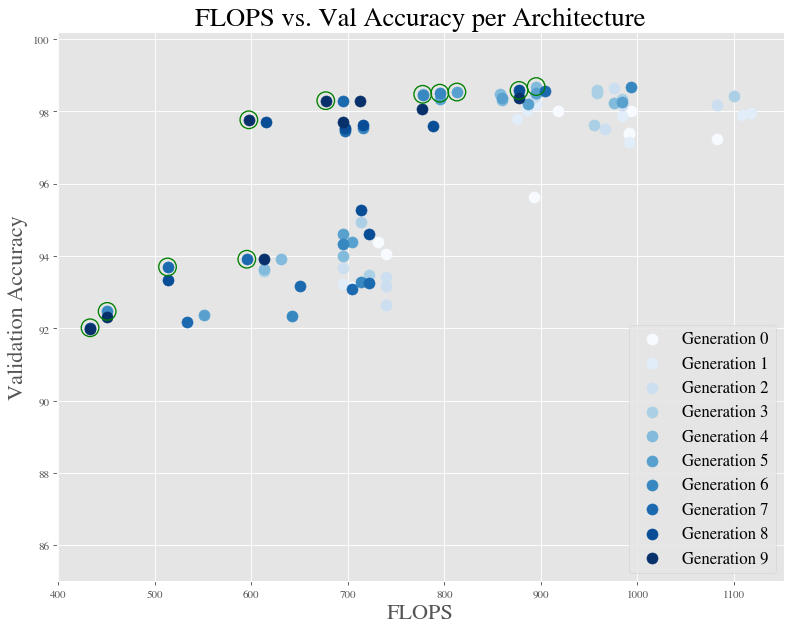

In [492]:
# 1e14
print("For 1e14:")

by_arch = gpu1_1e14.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
print(pareto_optimal_arches)
plt = make_graphic(one_line, pareto_optimal_arches)
plt.show()
plt.savefig('figures/pareto_1gpu_1e14.png')

For 1e15:
    arch  final_acc      flops  converged
78    78  99.993701   921.9475      False
73    73  99.993701   993.2103       True
53    53  99.987402  1002.2103      False
9      9  99.987402  1002.2103       True
33    33  99.981104   903.9475      False
    arch  final_acc     flops  converged  pareto_optimal
18    18  99.962207  886.7980      False            True
33    33  99.981104  903.9475      False            True
43    43  98.752834  613.4673       True            True
48    48  99.162257  615.0427       True            True
71    71  99.949609  793.2471      False            True
77    77  99.955908  886.2344       True            True
78    78  99.993701  921.9475      False            True
93    93  97.864701  533.2046       True            True
96    96  98.412698  597.3296       True            True
99    99  99.937012  695.2712       True            True


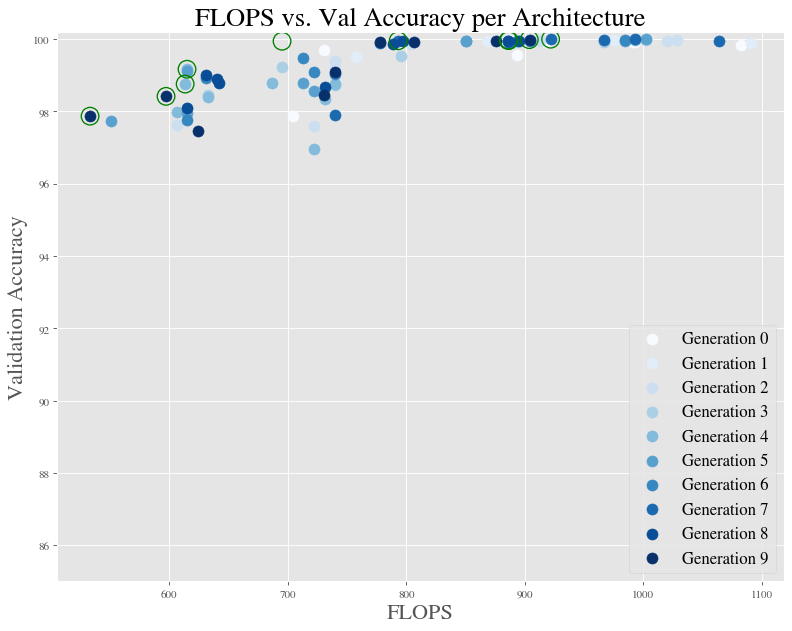

In [482]:
# 1e15
print("For 1e15:")

by_arch = gpu1_1e15.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
print(pareto_optimal_arches)
plt = make_graphic(one_line, pareto_optimal_arches)
plt.show()
plt.savefig('figures/pareto_1gpu_1e15.png')

For 1e16:
    arch  final_acc     flops  converged
0      0      100.0  740.0186      False
61    61      100.0  613.1805      False
32    32      100.0  722.0186       True
33    33      100.0  912.9475      False
36    36      100.0  722.0186      False
    arch   final_acc     flops  converged  pareto_optimal
75    75   99.666163  334.8169       True            True
76    76  100.000000  513.3423      False            True
84    84   99.993701  495.3423       True            True
86    86   99.974805  450.7927       True            True
88    88   99.798438  352.8169       True            True
90    90   99.968506  432.7927       True            True
91    91   99.949609  415.0796      False            True
96    96   97.927690  251.2500       True            True


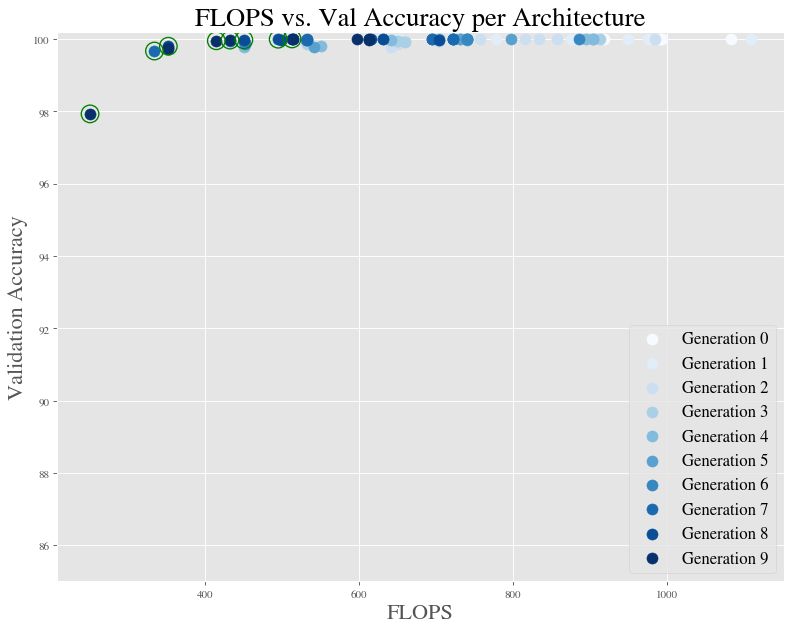

In [483]:
# 1e16
print("For 1e16:")

by_arch = gpu1_1e16.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
print(pareto_optimal_arches)
plt = make_graphic(one_line, pareto_optimal_arches)
plt.show()
plt.savefig('figures/pareto_1gpu_1e16.png')

### Multi-GPU without PENGUIN

For 1e14:
    arch  final_acc      flops  converged
10    10  98.759133  1108.8993      False
23    23  98.626858  1073.4730      False
60    60  98.582766   990.7743       True
30    30  98.551272  1099.8993       True
82    82  98.551272  1108.8993       True
    arch  final_acc      flops  converged  pareto_optimal
10    10  98.759133  1108.8993      False            True
23    23  98.626858  1073.4730      False            True
56    56  93.424036   513.0555       True            True
59    59  97.751323   615.2853       True            True
60    60  98.582766   990.7743       True            True
66    66  98.431595   810.9603       True            True
72    72  98.425296   712.9844       True            True
83    83  93.902746   531.0555       True            True
95    95  92.573696   415.0796      False            True
97    97  98.463089   911.0853      False            True


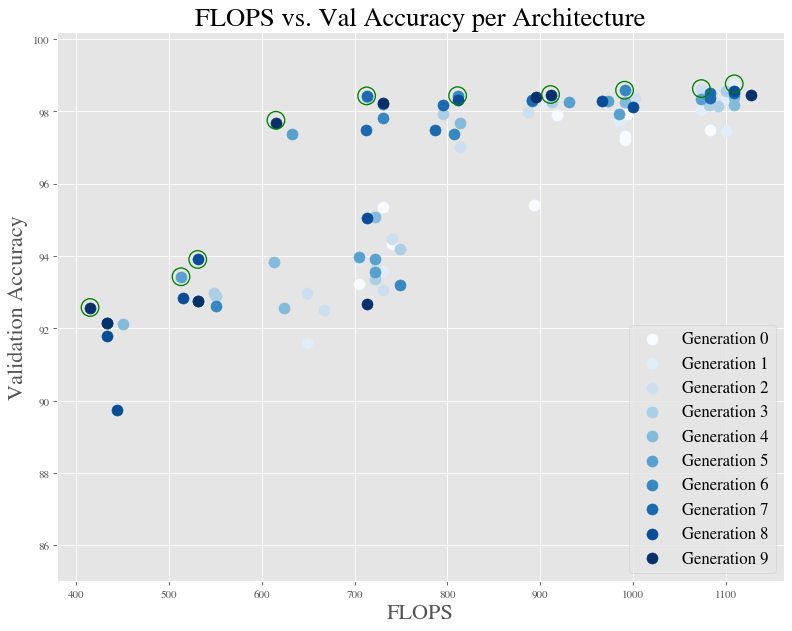

In [484]:
# 1e14
print("For 1e14:")

by_arch = gpu4_1e14.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
print(pareto_optimal_arches)
plt = make_graphic(one_line, pareto_optimal_arches)
plt.show()
plt.savefig('figures/pareto_4gpu_1e14.png')

For 1e15:
    arch  final_acc      flops  converged
17    17  99.993701  1100.1861       True
64    64  99.987402   877.2344       True
67    67  99.987402  1100.1861       True
9      9  99.987402  1002.2103      False
29    29  99.981104  1100.1861       True
    arch  final_acc      flops  converged  pareto_optimal
17    17  99.993701  1100.1861       True            True
37    37  99.962207   795.1094      False            True
38    38  99.955908   777.3962      False            True
62    62  99.212648   548.7686       True            True
64    64  99.987402   877.2344       True            True
81    81  99.332326   613.1805      False            True
86    86  99.577979   695.3055       True            True
90    90  99.930713   777.1094      False            True


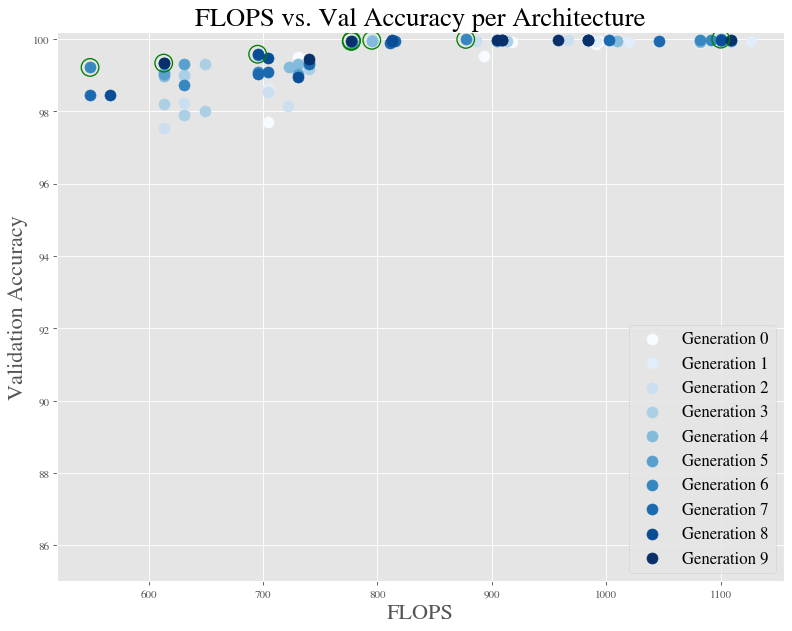

In [485]:
# 1e15
print("For 1e15:")

by_arch = gpu4_1e15.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
print(pareto_optimal_arches)
plt = make_graphic(one_line, pareto_optimal_arches)
plt.show()
plt.savefig('figures/pareto_4gpu_1e15.png')

For 1e16:
    arch  final_acc     flops  converged
50    50      100.0  731.0186      False
29    29      100.0  797.5353      False
84    84      100.0  513.0555       True
83    83      100.0  677.2712      False
82    82      100.0  530.7686       True
    arch   final_acc     flops  converged  pareto_optimal
88    88  100.000000  495.3423       True            True
90    90   99.962207  432.7927      False            True


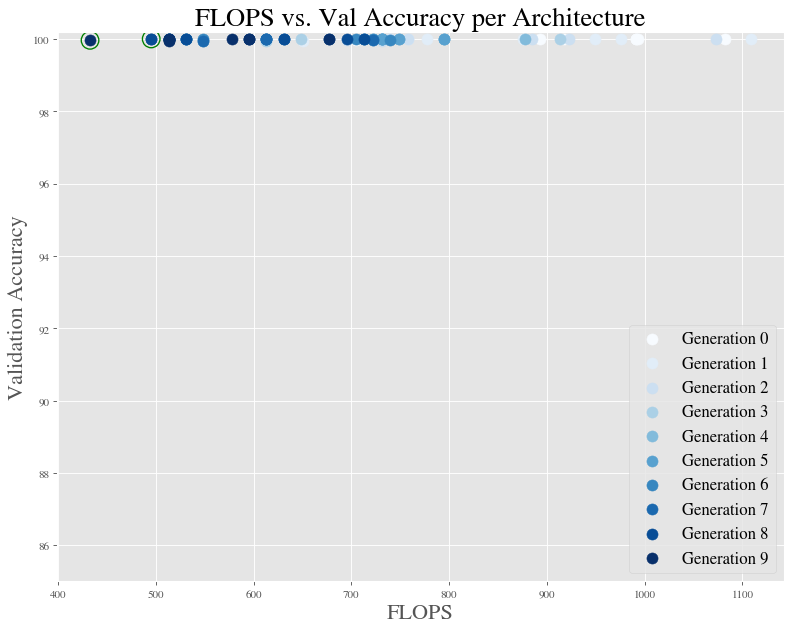

In [486]:
# 1e16
print("For 1e16:")

by_arch = gpu4_1e16.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
print(pareto_optimal_arches)
plt = make_graphic(one_line, pareto_optimal_arches)
plt.show()
plt.savefig('figures/pareto_4gpu_1e16.png')

### Multi-GPU with PENGUIN

For 1e14:
    arch  final_acc     flops  converged
20    20  98.544974  984.4971      False
64    64  98.507181  993.3537       True
51    51  98.463089  975.6405      False
82    82  98.368607  877.5112      False
22    22  98.330814  893.0853      False
    arch  final_acc     flops  converged  pareto_optimal
20    20  98.544974  984.4971      False            True
51    51  98.463089  975.6405      False            True
59    59  96.649030  517.2993       True            True
72    72  98.318216  713.2612      False            True
78    78  91.591081  352.5300      False            True
82    82  98.368607  877.5112      False            True
83    83  98.274124  695.2612       True            True
89    89  93.065004  450.5059      False            True
92    92  97.026959  535.2993      False            True
93    93  97.959184  632.9984      False            True
96    96  91.679264  434.6550       True            True


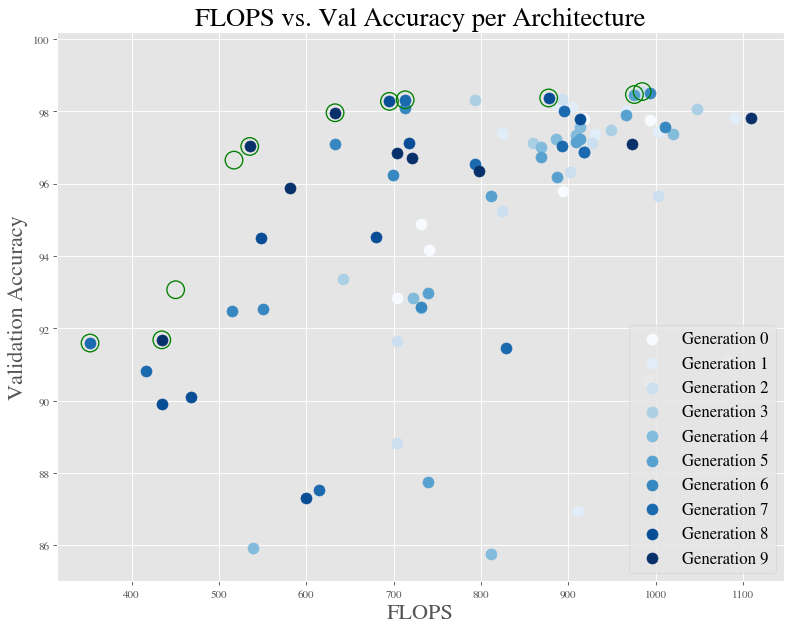

In [490]:
# 1e14
print("For 1e14:")

by_arch = gpu4_1e14_stopping.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
print(pareto_optimal_arches)
plt = make_graphic(one_line, pareto_optimal_arches)
plt.show()
plt.savefig('figures/pareto_4gpu_1e14_penguin.png')

For 1e15:
    arch  final_acc      flops  converged
77    77  99.974805   973.6348      False
63    63  99.968506  1064.7598      False
98    98  99.955908  1064.7598      False
49    49  99.955908  1082.4730      False
50    50  99.930713   875.9357      False
    arch  final_acc     flops  converged  pareto_optimal
37    37  97.902494  595.4673       True            True
40    40  99.275636  697.4103       True            True
41    41  99.918115  875.6590      False            True
50    50  99.930713  875.9357      False            True
61    61  95.332577  515.2046       True            True
64    64  99.911817  704.4046      False            True
72    72  98.507181  613.4673       True            True
73    73  94.683799  434.9419       True            True
77    77  99.974805  973.6348      False            True
81    81  99.905518  697.6971      False            True
85    85  96.705719  532.9177       True            True
92    92  99.118166  617.7112       True            Tr

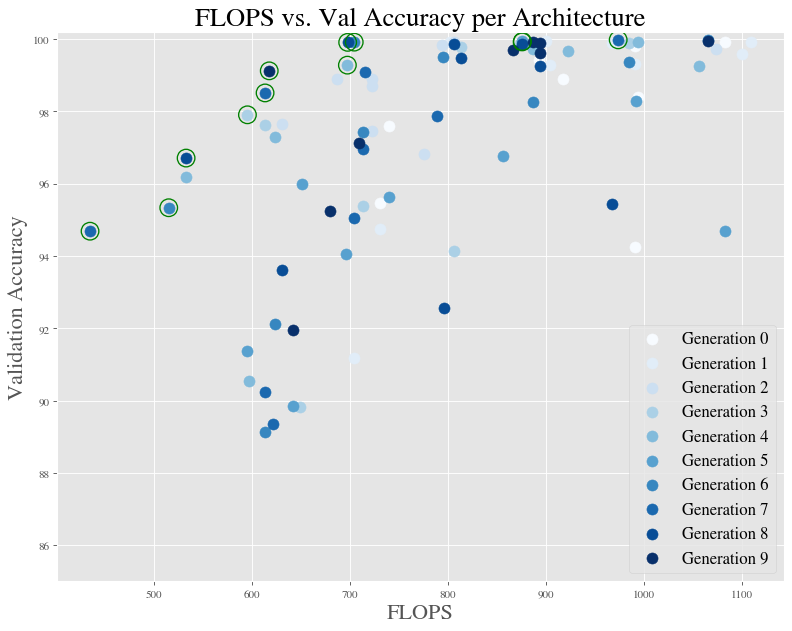

In [488]:
# 1e15
print("For 1e15:")

by_arch = gpu4_1e15_stopping.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
print(pareto_optimal_arches)

plt = make_graphic(one_line, pareto_optimal_arches)
plt.show()
plt.savefig('figures/pareto_4gpu_1e15_penguin.png')

For 1e16:
    arch  final_acc     flops  converged
99    99      100.0  679.6971      False
81    81      100.0  777.3962       True
24    24      100.0  973.3480      False
88    88      100.0  759.6831      False
28    28      100.0  868.5212      False
    arch   final_acc     flops  converged  pareto_optimal
58    58   99.993701  595.4673      False            True
62    62  100.000000  599.7112      False            True
72    72   95.679012  269.2500      False            True
83    83   95.905770  360.3750       True            True
84    84   99.735450  434.9419      False            True


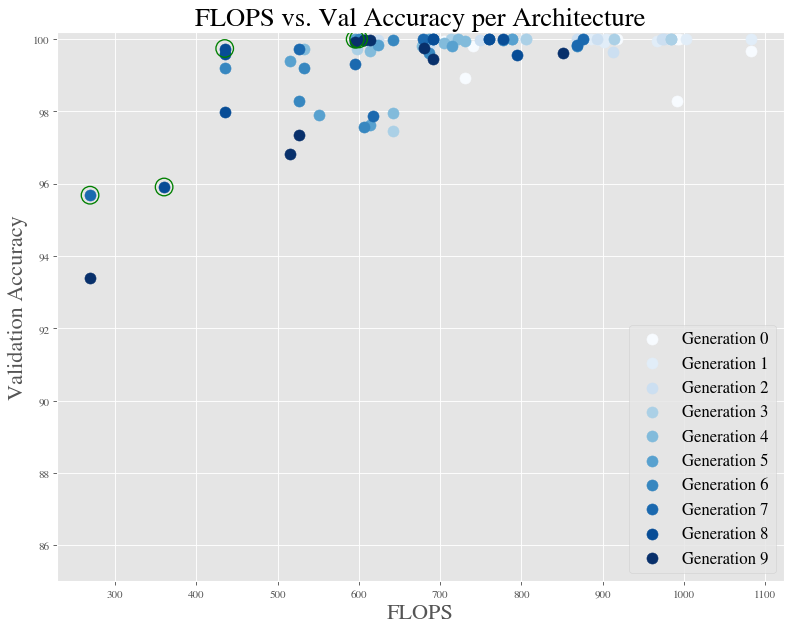

In [489]:
# 1e16
print("For 1e16:")

by_arch = gpu4_1e16_stopping.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
print(pareto_optimal_arches)
plt = make_graphic(one_line, pareto_optimal_arches)
plt.show()
plt.savefig('figures/pareto_4gpu_1e16_penguin.png')